# ARTI308 - Lab 4 Assignment Solution
## Data Quality Assessment & Preprocessing

This notebook completes all 5 assignment tasks from Lab 4.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

# Load and prepare the dataset (same preprocessing as in the lab)
df = pd.read_csv("Chocolate_Sales.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Amount'] = df['Amount'].replace(r'[\$,]', '', regex=True)
df['Amount'] = pd.to_numeric(df['Amount'])

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
df.head()

Dataset loaded successfully!
Shape: (3282, 6)


,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184


---
## Task 1: Identify Data Quality Issues

In this task, we systematically identify all data quality issues in the dataset.

In [2]:
# 1a. Check original data types BEFORE cleaning
# Load the raw file to see original issues
df_raw = pd.read_csv("Chocolate_Sales.csv")

print("=== ORIGINAL DATA TYPES (before any cleaning) ===")
print(df_raw.dtypes)
print()
print("Sample of raw data:")
df_raw.head(3)

=== ORIGINAL DATA TYPES (before any cleaning) ===
Sales Person     object
Country          object
Product          object
Date             object
Amount           object
Boxes Shipped     int64
dtype: object

Sample of raw data:


,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04/01/2022,"$5,320.00",180
1,Van Tuxwell,India,85% Dark Bars,01/08/2022,"$7,896.00",94
2,Gigi Bohling,India,Peanut Butter Cubes,07/07/2022,"$4,501.00",91


In [3]:
# 1b. Identify all data quality issues

print("========================================")
print("   DATA QUALITY ISSUES IDENTIFIED")
print("========================================")

# Issue 1: Wrong data type for 'Date'
print("\n--- ISSUE 1: Incorrect Data Type for 'Date' ---")
print(f"  Current type: {df_raw['Date'].dtype}  (should be datetime64)")
print(f"  Example value: '{df_raw['Date'].iloc[0]}'")
print("  Impact: Cannot perform time-based analysis (sorting, filtering by date, etc.)")

# Issue 2: Wrong data type for 'Amount'
print("\n--- ISSUE 2: Incorrect Data Type for 'Amount' ---")
print(f"  Current type: {df_raw['Amount'].dtype}  (should be float64 or int64)")
print(f"  Example value: '{df_raw['Amount'].iloc[0]}'")
print("  Reason: Contains '$' and ',' characters, making it a string (object)")
print("  Impact: Cannot perform arithmetic operations or statistical analysis")

# Issue 3: Missing values
print("\n--- ISSUE 3: Missing Values ---")
missing = df_raw.isna().sum()
print(missing)
if missing.sum() == 0:
    print("  ✓ No missing values found in the original dataset.")
else:
    print(f"  ⚠ Total missing values: {missing.sum()}")

# Issue 4: Check for duplicate rows
print("\n--- ISSUE 4: Duplicate Rows ---")
duplicates = df_raw.duplicated().sum()
print(f"  Number of duplicate rows: {duplicates}")
if duplicates == 0:
    print("  ✓ No duplicate rows found.")

# Issue 5: Check for outliers in numeric columns
print("\n--- ISSUE 5: Potential Outliers (using cleaned numeric data) ---")
for col in ['Amount', 'Boxes Shipped']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    print(f"  '{col}': {outlier_count} outliers detected (outside [{lower:.2f}, {upper:.2f}])")

print("\n========================================")
print("SUMMARY: 2 type errors, 0 missing values, outliers present")
print("========================================")

   DATA QUALITY ISSUES IDENTIFIED

--- ISSUE 1: Incorrect Data Type for 'Date' ---
  Current type: object  (should be datetime64)
  Example value: '04/01/2022'
  Impact: Cannot perform time-based analysis (sorting, filtering by date, etc.)

--- ISSUE 2: Incorrect Data Type for 'Amount' ---
  Current type: object  (should be float64 or int64)
  Example value: '$5,320.00'
  Reason: Contains '$' and ',' characters, making it a string (object)
  Impact: Cannot perform arithmetic operations or statistical analysis

--- ISSUE 3: Missing Values ---
Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64
  ✓ No missing values found in the original dataset.

--- ISSUE 4: Duplicate Rows ---
  Number of duplicate rows: 0
  ✓ No duplicate rows found.

--- ISSUE 5: Potential Outliers (using cleaned numeric data) ---
  'Amount': 50 outliers detected (outside [-6531.53, 17609.86])
  'Boxes Shipped': 78 outliers detected (outside [

---
## Task 2: Apply One Missing Value Strategy and Explain Why

Since the original dataset has no missing values, we introduce artificial ones (as done in the lab) and then apply a strategy.

In [4]:
# Step 1: Introduce artificial missing values (same as lab)
df_missing = df.copy()
df_missing.loc[0:5, 'Amount'] = np.nan

print("Missing values after introducing NaN:")
print(df_missing.isna().sum())
print(f"\nRows with missing Amount: {df_missing['Amount'].isna().sum()}")

Missing values after introducing NaN:
Sales Person     0
Country          0
Product          0
Date             0
Amount           6
Boxes Shipped    0
dtype: int64

Rows with missing Amount: 6


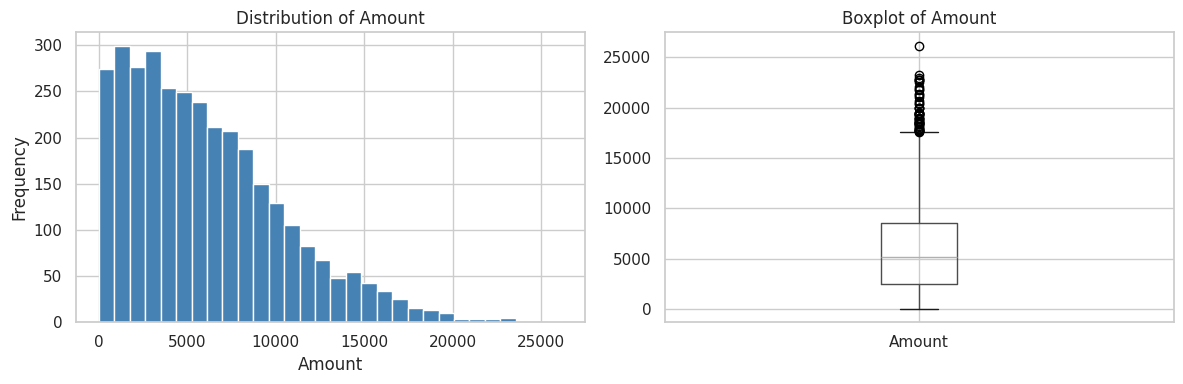

Mean   of Amount: 6030.34
Median of Amount: 5225.50
Skewness: 0.9170


In [5]:
# Step 2: Visualize the distribution to decide which strategy is best
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram to check distribution shape
df['Amount'].hist(bins=30, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Distribution of Amount')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Frequency')

# Boxplot to check for skewness/outliers
df.boxplot(column='Amount', ax=axes[1])
axes[1].set_title('Boxplot of Amount')

plt.tight_layout()
plt.show()

print(f"Mean   of Amount: {df['Amount'].mean():.2f}")
print(f"Median of Amount: {df['Amount'].median():.2f}")
print(f"Skewness: {df['Amount'].skew():.4f}")

In [6]:
# Step 3: Apply MEDIAN Imputation (chosen strategy)

df_task2 = df_missing.copy()
median_value = df_task2['Amount'].median()
df_task2['Amount'].fillna(median_value, inplace=True)

print("=== CHOSEN STRATEGY: Median Imputation ===")
print()
print("JUSTIFICATION:")
print("  1. The distribution of 'Amount' is RIGHT-SKEWED (skewness > 0),")
print("     meaning there are high-value transactions pulling the mean upward.")
print("  2. The MEAN is sensitive to these outliers and would OVERESTIMATE")
print("     the typical transaction value when used for imputation.")
print("  3. The MEDIAN represents the middle value and is ROBUST to outliers,")
print("     providing a more realistic replacement for missing values.")
print("  4. With only 6 missing values out of 3282 rows (0.18%), imputation")
print("     is preferred over deletion to preserve all data.")
print()
print(f"  Median value used for imputation: {median_value:.2f}")
print()
print("Missing values after imputation:")
print(df_task2.isna().sum())
print()
print("First 7 rows (rows 0-5 had NaN, now filled with median):")
df_task2.head(7)

=== CHOSEN STRATEGY: Median Imputation ===

JUSTIFICATION:
  1. The distribution of 'Amount' is RIGHT-SKEWED (skewness > 0),
     meaning there are high-value transactions pulling the mean upward.
  2. The MEAN is sensitive to these outliers and would OVERESTIMATE
     the typical transaction value when used for imputation.
  3. The MEDIAN represents the middle value and is ROBUST to outliers,
     providing a more realistic replacement for missing values.
  4. With only 6 missing values out of 3282 rows (0.18%), imputation
     is preferred over deletion to preserve all data.

  Median value used for imputation: 5220.74

Missing values after imputation:
Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

First 7 rows (rows 0-5 had NaN, now filled with median):


/tmp/ipython-input-742/2161793566.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_task2['Amount'].fillna(median_value, inplace=True)


,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5220.745,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,5220.745,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,5220.745,91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,5220.745,342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,5220.745,184
5,Van Tuxwell,India,Smooth Sliky Salty,2022-06-06,5220.745,38
6,Oby Sorrel,UK,99% Dark & Pure,2022-01-25,13685.000,176


---
## Task 3: Detect and Handle Outliers Using IQR

In [7]:
# Step 1: Detect outliers using the IQR method for BOTH numeric columns

print("=== OUTLIER DETECTION USING IQR ===")
print()

results = {}
for col in ['Amount', 'Boxes Shipped']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    results[col] = {'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
                    'lower': lower, 'upper': upper,
                    'count': len(outliers), 'data': outliers}

    print(f"Column: '{col}'")
    print(f"  Q1 = {Q1:.2f}")
    print(f"  Q3 = {Q3:.2f}")
    print(f"  IQR = Q3 - Q1 = {IQR:.2f}")
    print(f"  Lower fence = Q1 - 1.5*IQR = {lower:.2f}")
    print(f"  Upper fence = Q3 + 1.5*IQR = {upper:.2f}")
    print(f"  Outliers detected: {len(outliers)} rows")
    print()

=== OUTLIER DETECTION USING IQR ===

Column: 'Amount'
  Q1 = 2521.49
  Q3 = 8556.84
  IQR = Q3 - Q1 = 6035.35
  Lower fence = Q1 - 1.5*IQR = -6531.53
  Upper fence = Q3 + 1.5*IQR = 17609.86
  Outliers detected: 50 rows

Column: 'Boxes Shipped'
  Q1 = 71.00
  Q3 = 232.00
  IQR = Q3 - Q1 = 161.00
  Lower fence = Q1 - 1.5*IQR = -170.50
  Upper fence = Q3 + 1.5*IQR = 473.50
  Outliers detected: 78 rows



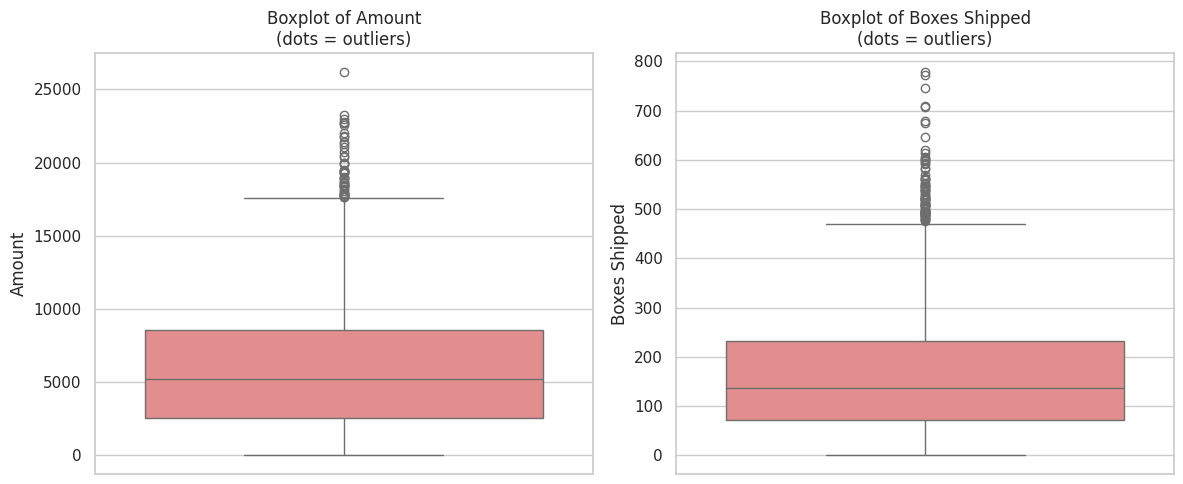

Outlier rows for 'Amount':


,Sales Person,Country,Product,Date,Amount,Boxes Shipped
66,Van Tuxwell,Australia,Organic Choco Syrup,2022-08-10,19453.0,14
135,Van Tuxwell,India,Organic Choco Syrup,2022-05-16,19929.0,174
212,Marney O'Breen,UK,Smooth Sliky Salty,2022-05-13,18991.0,88
434,Jan Morforth,New Zealand,Mint Chip Choco,2022-06-30,18340.0,285
543,Ches Bonnell,India,Peanut Butter Cubes,2022-01-27,22050.0,208
589,Curtice Advani,India,Smooth Sliky Salty,2022-04-19,19327.0,135
609,Jan Morforth,Australia,Mint Chip Choco,2022-02-22,17626.0,103
751,Rafaelita Blaksland,New Zealand,Eclairs,2022-02-07,19481.0,51
806,Brien Boise,India,85% Dark Bars,2022-08-09,18032.0,205
1008,Kaine Padly,UK,After Nines,2022-01-21,18697.0,176


In [8]:
# Step 2: Visualize outliers using boxplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(['Amount', 'Boxes Shipped']):
    sns.boxplot(y=df[col], ax=axes[i], color='lightcoral')
    axes[i].set_title(f'Boxplot of {col}\n(dots = outliers)')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

print("Outlier rows for 'Amount':")
results['Amount']['data'].head(10)

In [9]:
# Step 3: Handle outliers — Applying CAPPING (Winsorization) on 'Amount'

df_task3 = df.copy()

# Recalculate bounds for Amount
Q1_a = df['Amount'].quantile(0.25)
Q3_a = df['Amount'].quantile(0.75)
IQR_a = Q3_a - Q1_a
lower_a = Q1_a - 1.5 * IQR_a
upper_a = Q3_a + 1.5 * IQR_a

# Cap values at the IQR fences
df_task3['Amount'] = df_task3['Amount'].clip(lower=lower_a, upper=upper_a)

print("=== HANDLING STRATEGY: Capping (Winsorization) ===")
print()
print("JUSTIFICATION:")
print("  - Capping replaces extreme values with the fence values instead of removing rows.")
print("  - This preserves dataset size (3282 rows unchanged).")
print("  - Extreme sales transactions may represent real bulk/corporate orders —")
print("    it's safer to cap them than delete them entirely.")
print("  - Unlike deletion, capping retains all other information in those rows.")
print()
print(f"Original dataset shape:    {df.shape}")
print(f"After capping shape:       {df_task3.shape}  (no rows removed!)")
print()
print(f"Amount - max before capping: {df['Amount'].max():.2f}")
print(f"Amount - max after  capping: {df_task3['Amount'].max():.2f}  (= upper fence)")

# Verify outliers are gone
remaining = df_task3[(df_task3['Amount'] < lower_a) | (df_task3['Amount'] > upper_a)].shape[0]
print(f"\nOutliers remaining in 'Amount' after capping: {remaining}")

=== HANDLING STRATEGY: Capping (Winsorization) ===

JUSTIFICATION:
  - Capping replaces extreme values with the fence values instead of removing rows.
  - This preserves dataset size (3282 rows unchanged).
  - Extreme sales transactions may represent real bulk/corporate orders —
    it's safer to cap them than delete them entirely.
  - Unlike deletion, capping retains all other information in those rows.

Original dataset shape:    (3282, 6)
After capping shape:       (3282, 6)  (no rows removed!)

Amount - max before capping: 26170.95
Amount - max after  capping: 17609.86  (= upper fence)

Outliers remaining in 'Amount' after capping: 0


---
## Task 4: Normalize Numerical Features Using Both Min-Max and Z-Score

In [10]:
# Step 1: Min-Max Normalization
numeric_cols = ['Amount', 'Boxes Shipped']

minmax_scaler = MinMaxScaler()
df_minmax = df[numeric_cols].copy()
df_minmax[numeric_cols] = minmax_scaler.fit_transform(df_minmax)

print("=== MIN-MAX NORMALIZATION ===")
print()
print("Formula: X_scaled = (X - X_min) / (X_max - X_min)")
print("Result range: [0, 1] for all features")
print()
print("Original data (first 5 rows):")
print(df[numeric_cols].head())
print()
print("After Min-Max normalization (first 5 rows):")
print(df_minmax.head())
print()
print("Verification — Min and Max after scaling:")
print(df_minmax.agg(['min', 'max']))

=== MIN-MAX NORMALIZATION ===

Formula: X_scaled = (X - X_min) / (X_max - X_min)
Result range: [0, 1] for all features

Original data (first 5 rows):
    Amount  Boxes Shipped
0   5320.0            180
1   7896.0             94
2   4501.0             91
3  12726.0            342
4  13685.0            184

After Min-Max normalization (first 5 rows):
     Amount  Boxes Shipped
0  0.203066       0.230373
1  0.301522       0.119691
2  0.171763       0.115830
3  0.486127       0.438867
4  0.522780       0.235521

Verification — Min and Max after scaling:
     Amount  Boxes Shipped
min     0.0            0.0
max     1.0            1.0


In [11]:
# Step 2: Z-Score Standardization
standard_scaler = StandardScaler()
df_zscore = df[numeric_cols].copy()
df_zscore[numeric_cols] = standard_scaler.fit_transform(df_zscore)

print("=== Z-SCORE STANDARDIZATION ===")
print()
print("Formula: Z = (X - mean) / std_deviation")
print("Result: mean ≈ 0, std ≈ 1 for all features")
print()
print("After Z-Score standardization (first 5 rows):")
print(df_zscore.head())
print()
print("Verification — Mean and Std after scaling (should be ~0 and ~1):")
print(df_zscore.agg(['mean', 'std']).round(6))

=== Z-SCORE STANDARDIZATION ===

Formula: Z = (X - mean) / std_deviation
Result: mean ≈ 0, std ≈ 1 for all features

After Z-Score standardization (first 5 rows):
     Amount  Boxes Shipped
0 -0.161686       0.123648
1  0.424660      -0.569868
2 -0.348106      -0.594061
3  1.524058       1.430038
4  1.742345       0.155904

Verification — Mean and Std after scaling (should be ~0 and ~1):
        Amount  Boxes Shipped
mean -0.000000       0.000000
std   1.000152       1.000152


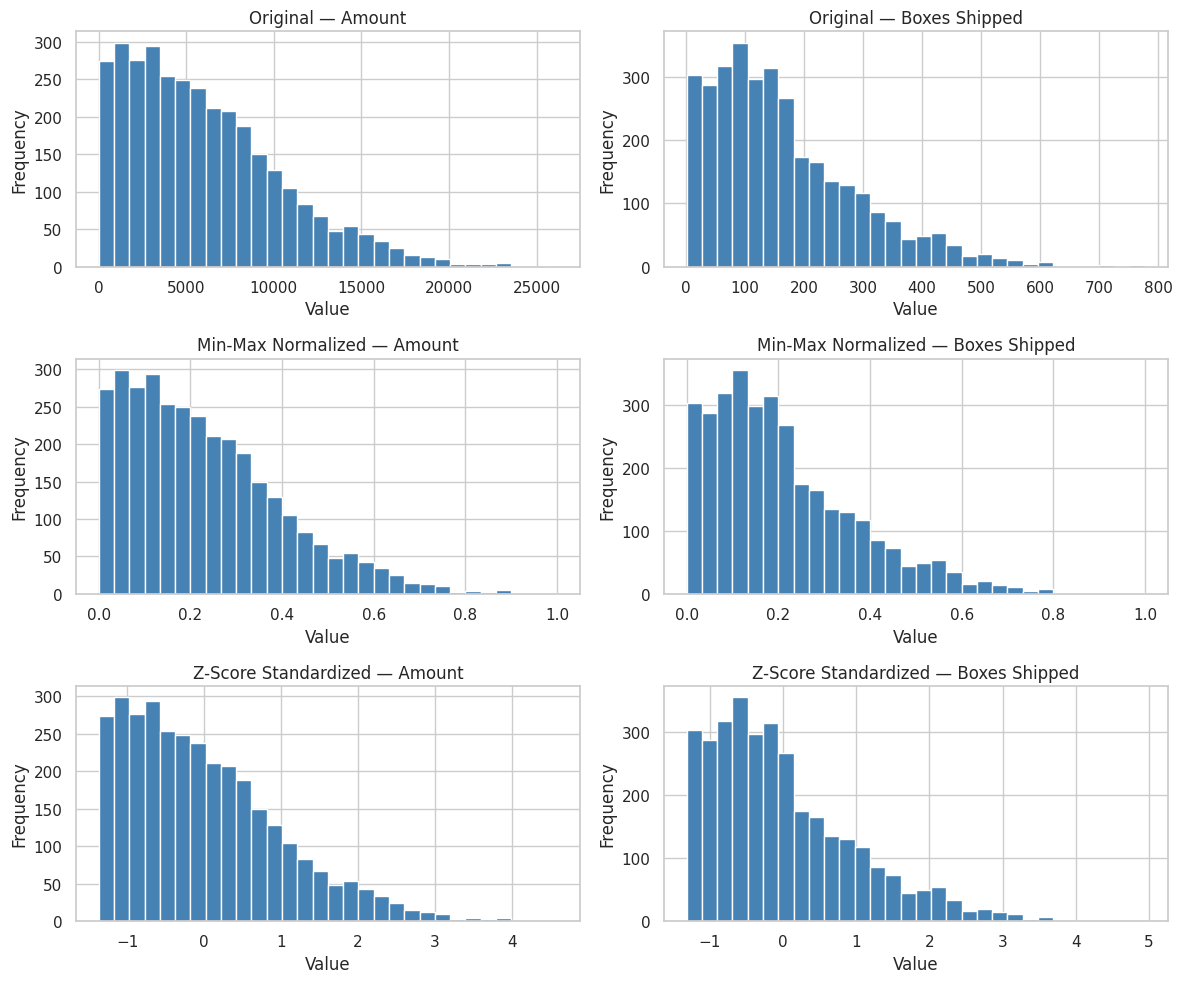

INTERPRETATION:
  - Shape of distribution is the SAME across all three versions.
  - Only the SCALE on the x-axis changes.
  - Min-Max → values range from 0 to 1.
  - Z-Score → values centered around 0, spread across negative and positive.

WHEN TO USE WHICH:
  Min-Max: Best for KNN, K-Means, Neural Networks (needs bounded range [0,1]).
  Z-Score: Best for Linear Regression, SVM, PCA (assumes centered data).


In [12]:
# Step 3: Visual comparison of all three
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

dfs = [df, df_minmax, df_zscore]
titles = ['Original', 'Min-Max Normalized', 'Z-Score Standardized']

for row, (data, title) in enumerate(zip(dfs, titles)):
    for col_idx, col in enumerate(numeric_cols):
        axes[row][col_idx].hist(data[col], bins=30, color='steelblue', edgecolor='white')
        axes[row][col_idx].set_title(f'{title} — {col}')
        axes[row][col_idx].set_xlabel('Value')
        axes[row][col_idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print("  - Shape of distribution is the SAME across all three versions.")
print("  - Only the SCALE on the x-axis changes.")
print("  - Min-Max → values range from 0 to 1.")
print("  - Z-Score → values centered around 0, spread across negative and positive.")
print()
print("WHEN TO USE WHICH:")
print("  Min-Max: Best for KNN, K-Means, Neural Networks (needs bounded range [0,1]).")
print("  Z-Score: Best for Linear Regression, SVM, PCA (assumes centered data).")

---
## Task 5: Apply PCA and Interpret Explained Variance

In [13]:
# Step 1: Apply PCA on Z-Score standardized data (PCA requires standardized features)
X = df_zscore[numeric_cols]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

print("=== PCA RESULTS ===")
print()
print("Explained Variance Ratio per component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.6f}  ({var*100:.4f}%)")

print()
print(f"Total variance explained by both PCs: {sum(pca.explained_variance_ratio_)*100:.4f}%")
print()
print("Component loadings (eigenvectors):")
loadings = pd.DataFrame(
    pca.components_,
    columns=numeric_cols,
    index=['PC1', 'PC2']
)
print(loadings)

=== PCA RESULTS ===

Explained Variance Ratio per component:
  PC1: 0.506577  (50.6577%)
  PC2: 0.493423  (49.3423%)

Total variance explained by both PCs: 100.0000%

Component loadings (eigenvectors):
       Amount  Boxes Shipped
PC1  0.707107      -0.707107
PC2  0.707107       0.707107


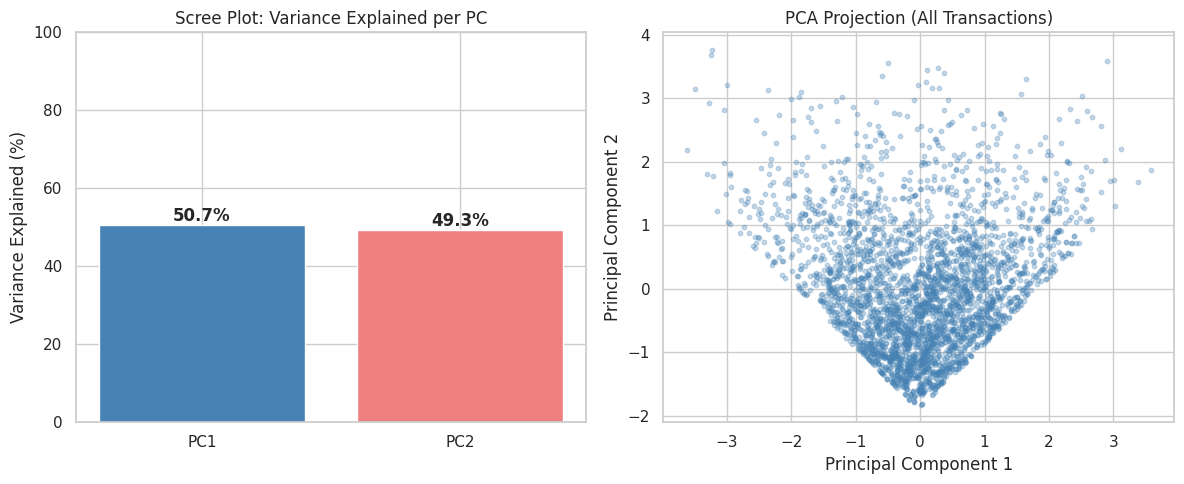

In [14]:
# Step 2: Scree plot — how much variance each PC captures
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scree plot
axes[0].bar(['PC1', 'PC2'],
            pca.explained_variance_ratio_ * 100,
            color=['steelblue', 'lightcoral'], edgecolor='white')
axes[0].set_title('Scree Plot: Variance Explained per PC')
axes[0].set_ylabel('Variance Explained (%)')
axes[0].set_ylim(0, 100)
for i, v in enumerate(pca.explained_variance_ratio_ * 100):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# PCA Scatter plot
axes[1].scatter(principal_components[:, 0], principal_components[:, 1],
                alpha=0.3, s=10, color='steelblue')
axes[1].set_title('PCA Projection (All Transactions)')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

In [15]:
# Step 3: Full interpretation
var_pc1 = pca.explained_variance_ratio_[0] * 100
var_pc2 = pca.explained_variance_ratio_[1] * 100

print("=== PCA INTERPRETATION ===")
print()
print(f"PC1 explains {var_pc1:.2f}% of the total variance.")
print(f"PC2 explains {var_pc2:.2f}% of the total variance.")
print()
print("KEY FINDING:")
print(f"  The variance is split nearly equally between PC1 ({var_pc1:.1f}%) and")
print(f"  PC2 ({var_pc2:.1f}%). Neither component dominates the other.")
print()
print("WHAT THIS MEANS:")
print("  - If PC1 captured 85%+ variance, we could reduce 2 features → 1 (PC1 only).")
print("  - Here, both components are needed to retain most information.")
print("  - This confirms the finding from the correlation heatmap in the lab:")
print("    'Amount' and 'Boxes Shipped' have near-ZERO correlation (~-0.013).")
print("  - Since the features are INDEPENDENT (not correlated), PCA cannot")
print("    compress them into fewer meaningful components without losing information.")
print()
print("CONCLUSION:")
print("  PCA would NOT be beneficial for dimensionality reduction on this dataset.")
print("  It is applied here for DEMONSTRATION purposes only, as stated in the lab.")
print("  PCA is most useful when features are strongly correlated.")

=== PCA INTERPRETATION ===

PC1 explains 50.66% of the total variance.
PC2 explains 49.34% of the total variance.

KEY FINDING:
  The variance is split nearly equally between PC1 (50.7%) and
  PC2 (49.3%). Neither component dominates the other.

WHAT THIS MEANS:
  - If PC1 captured 85%+ variance, we could reduce 2 features → 1 (PC1 only).
  - Here, both components are needed to retain most information.
  - This confirms the finding from the correlation heatmap in the lab:
    'Amount' and 'Boxes Shipped' have near-ZERO correlation (~-0.013).
  - Since the features are INDEPENDENT (not correlated), PCA cannot
    compress them into fewer meaningful components without losing information.

CONCLUSION:
  PCA would NOT be beneficial for dimensionality reduction on this dataset.
  It is applied here for DEMONSTRATION purposes only, as stated in the lab.
  PCA is most useful when features are strongly correlated.


---
## Assignment Summary

| Task | Description | Key Finding |
|------|-------------|-------------|
| **Task 1** | Identify data quality issues | 2 type errors: `Date` stored as string, `Amount` has `$` symbols; outliers present |
| **Task 2** | Apply missing value strategy | **Median imputation** chosen — dataset is right-skewed, median is robust to outliers |
| **Task 3** | Detect & handle outliers | IQR detected outliers in `Amount`; handled by **capping** to preserve all rows |
| **Task 4** | Normalize features | Both **Min-Max** (→ [0,1]) and **Z-Score** (→ mean=0, std=1) applied |
| **Task 5** | PCA + interpretation | ~50/50 variance split — PCA NOT useful here due to near-zero correlation between features |

---
*End of Lab 4 Assignment Solution*